# Using bandits to learn probabilities for the search space

To learn probabilities for the search space, the `Brush` estimators (not the DEAP!) uses a multi-armed bandit approach. 

This allows it to dynamically adjust the sampling probabilities of different operations based on their performance.

Not only it can learn how to sample terminals, but it also learns which mutations are useful and which are not. This is also important, as the mutations are responsible for sampling from the search space.

In this notebook, we show how to set this configuration, and how it changes the probabilities.

In [1]:
import pandas as pd
from pybrush import Dataset, SearchSpace
from pybrush import BrushRegressor

df = pd.read_csv('../examples/datasets/d_enc.csv')
X = df.drop(columns='label')
y = df['label']

data = Dataset(X,y)

search_space = SearchSpace(data)

This is the original search space using the loaded dataset. 

In [2]:
print( search_space.print() )

=== Search space ===
terminal_map: {"ArrayB": ["1.00"], "ArrayI": ["x_5", "x_7", "1.00"], "ArrayF": ["x_0", "x_1", "x_2", "x_3", "x_4", "x_6", "1.00"]}
terminal_weights: {"ArrayB": [1], "ArrayI": [0.014733159, 0.037457366, 0.026095262], "ArrayF": [0.6343385, 0.67299956, 0.42711574, 0.8625447, 0.8957853, 0.20750472, 0.6167148]}
SplitBest node_map[ArrayI][["ArrayI", "ArrayI"]][SplitBest] = 1.00*SplitBest, weight = 1
Div node_map[ArrayI][["ArrayI", "ArrayI"]][Div] = 1.00*Div, weight = 1
Mul node_map[ArrayI][["ArrayI", "ArrayI"]][Mul] = 1.00*Mul, weight = 1
Sub node_map[ArrayI][["ArrayI", "ArrayI"]][Sub] = 1.00*Sub, weight = 1
Pow node_map[ArrayI][["ArrayI", "ArrayI"]][Pow] = 1.00*Pow, weight = 1
Add node_map[ArrayI][["ArrayI", "ArrayI"]][Add] = 1.00*Add, weight = 1
Tanh node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Tanh] = 1.00*Tanh, weight = 1
Softmax node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Softmax] = 1.00*Softmax, weight = 1
Logistic node_map[MatrixF][[

There are two important settings for this:

- `bandit`, which specifies which strategy will be used to learn the probabilities, and
- `weights_init`, which will initialize the sampling probabilities for terminals in the search space based on the correlation between each terminal and the target variable.

In [3]:
est = BrushRegressor(
    functions=['SplitOn','Add','Exp','Sub', 'SplitBest',
               'Mul','Sin','Cos','Exp','Logabs'],
    max_gens=100,
    pop_size=100,
    max_stall=20,
    objectives=["scorer", "linear_complexity"],
    
    # Changing search space sampling probabilities
    bandit='thompson',
    weights_init=True,
    use_arch=False,
    
    verbosity=1
)

In [4]:
est.fit(X,y)

Completed  87% [=================   ]saving final population as archive...


,pop_size,100
,max_gens,100
,max_stall,20
,max_time,-1
,verbosity,1
,algorithm,'nsga2'
,mode,'regression'
,max_depth,10
,max_size,100
,num_islands,5
,mig_prob,0.05


In [5]:
from sklearn.metrics import root_mean_squared_error

y_pred = est.predict(X)
print('R2 score:', est.score(X,y))
print('RMSE    :', root_mean_squared_error(y, y_pred))

R2 score: 0.9497923125303123
RMSE    : 2.130264977866352


model: 0.51*Sub(If(x0>0.75,If(x0>0.81,Add(7.63*x4,-7.19*Cos(311.56*Cos(-36.80*x0))),114.37*Cos(271.54*x0)),Sub(54.38,43.94*x0)),-28.99*x6)


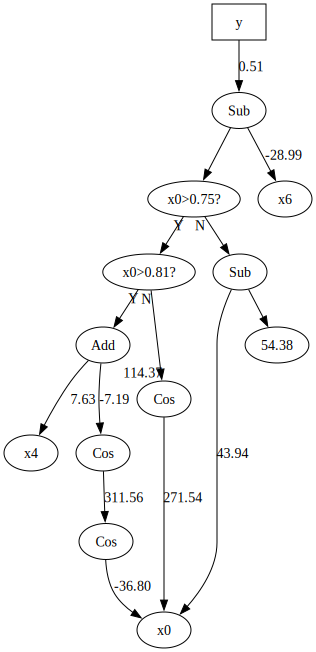

In [6]:
import graphviz

print('model:', est.best_estimator_.get_model())

model = est.best_estimator_.get_model("dot")
graphviz.Source(model)

The attribute `search_space_` is an original copy and it is not changed.

In [7]:
est.search_space_.print()

=== Search space ===
terminal_map: {"ArrayB": ["1.00"], "ArrayI": ["x5", "x7", "1.00"], "ArrayF": ["x0", "x1", "x2", "x3", "x4", "x6", "1.00"]}
terminal_weights: {"ArrayB": [1], "ArrayI": [0.014733159, 0.037457366, 0.026095262], "ArrayF": [0.6343385, 0.67299956, 0.42711574, 0.8625447, 0.8957853, 0.20750472, 0.6167148]}
Mul node_map[ArrayI][["ArrayI", "ArrayI"]][Mul] = 1.00*Mul, weight = 1
SplitBest node_map[ArrayI][["ArrayI", "ArrayI"]][SplitBest] = 1.00*SplitBest, weight = 1
Sub node_map[ArrayI][["ArrayI", "ArrayI"]][Sub] = 1.00*Sub, weight = 1
Add node_map[ArrayI][["ArrayI", "ArrayI"]][Add] = 1.00*Add, weight = 1
Logabs node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Logabs] = 1.00*Logabs, weight = 1
Sin node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Sin] = 1.00*Sin, weight = 1
Exp node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Exp] = 1.00*Exp, weight = 1
Cos node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Cos] = 1.00*Cos, weight = 1


When we call `fit`, the Brush engine is set to run and return the best individual. Then, the engine is stored as an attribute in our estimator, called `engine_`, and we can retrieve the learned probabilities by looking at the engine's search space.

In [8]:
est.engine_.search_space.print()

=== Search space ===
terminal_map: {"ArrayB": ["1.00"], "ArrayI": ["x5", "x7", "1.00"], "ArrayF": ["x0", "x1", "x2", "x3", "x4", "x6", "1.00"]}
terminal_weights: {"ArrayB": [0.7408707], "ArrayI": [0.67836016, 0.39627594, 0.22448048], "ArrayF": [0.061302267, 0.78965175, 0.056018297, 0.124067985, 0.72483844, 0.7680581, 0.18998615]}
Mul node_map[ArrayI][["ArrayI", "ArrayI"]][Mul] = 1.00*Mul, weight = 0.56478465
Sub node_map[ArrayI][["ArrayI", "ArrayI"]][Sub] = 1.00*Sub, weight = 0.3705131
SplitBest node_map[ArrayI][["ArrayI", "ArrayI"]][SplitBest] = 1.00*SplitBest, weight = 0.50930417
Add node_map[ArrayI][["ArrayI", "ArrayI"]][Add] = 1.00*Add, weight = 0.7974087
Sin node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Sin] = 1.00*Sin, weight = 0.7320208
Logabs node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Logabs] = 1.00*Logabs, weight = 0.38496196
Cos node_map[MatrixF][["ArrayF", "ArrayF", "ArrayF", "ArrayF"]][Cos] = 1.00*Cos, weight = 0.7948188
Exp node_map[MatrixF][

Mutation probabilities are stored in the parameters, not the search space. The same way that we can have the original and the learned probabilities by looking at the instance references and the instance's engine reference, we can look the learned probabilities.

In [9]:
print(est.parameters_.cx_prob)
print(est.parameters_.mutation_probs)

0.1428571492433548
{'delete': 0.1666666716337204, 'insert': 0.1666666716337204, 'point': 0.1666666716337204, 'subtree': 0.1666666716337204, 'toggle_weight_off': 0.1666666716337204, 'toggle_weight_on': 0.1666666716337204}


In [10]:
print(est.engine_.params.cx_prob)
print(est.engine_.params.mutation_probs)

0.009999999776482582
{'delete': 0.009999999776482582, 'insert': 0.009999999776482582, 'point': 0.009999999776482582, 'subtree': 0.009999999776482582, 'toggle_weight_off': 0.009999999776482582, 'toggle_weight_on': 0.009999999776482582}


## Comparing convergences

In the code below we run a simple experiment using the evolution log to compare convergence curves using different types of bandits

In [11]:
import tempfile

# Running 5x each algorithm and saving its convergence data
bandits = ['dummy', 'thompson', 'dynamic_thompson']
results = {b:[] for b in bandits}

with tempfile.TemporaryDirectory() as tmpdirname:
    for bandit in bandits:
        print(f"Running bandit: {bandit}")
        for run in range(10):
            logfile = f"{tmpdirname}/log_bandit={bandit}_run={run}.csv"
            
            est = BrushRegressor(
                functions=[
                    'Exp', 'Sub', 'Add', 'SplitBest', # 'SplitOn', # 'And', 'Or', #
                    # 'Mul', 'Sin', 'Cos', 'Exp', 'Logabs'
                ],
                max_gens=50,
                pop_size=100,
                max_stall=100, # avoiding early stopping --- we want to see the full convergence
                max_depth=5,
                objectives=["scorer", "linear_complexity"],
                bandit=bandit,
                weights_init=True,
                cx_prob = 1/10,
                mutation_probs = {
                    "point"             : 2/10,
                    "insert"            : 2/10,
                    "delete"            : 1/10,
                    "subtree"           : 2/10,
                    "toggle_weight_on"  : 1/10,
                    "toggle_weight_off" : 1/10 },
                use_arch=False,
                logfile=logfile,
                verbosity=1
            ).fit(X.astype(float),y)

            print('model:', est.best_estimator_.get_model())
            
            results[bandit] .append({'run'       : run,
                                    'model'      : est.best_estimator_.get_model(),
                                    'size'       : est.best_estimator_.fitness.size,
                                    'loss_v'     : est.best_estimator_.fitness.loss_v,
                                    'complexity' : est.best_estimator_.fitness.complexity,
                                    # 'linear_complexity' : est.best_estimator_.fitness.linear_complexity,
                                    'log'        : pd.read_csv(logfile) # loading logfile and keeping it
                                    }) 

Running bandit: dummy
Completed 100% [====================]
saving final population as archive...
model: Sub(If(x0>0.75,Sub(Add(If(x0>0.81,198.64,262.82*x0),-129.60),0.13*Add(x3,211.13*x0)),0.02*x1),-14.75*x6)
Completed 100% [====================]
saving final population as archive...
model: Sub(0.01*Add(Add(Sub(If(x0>0.75,If(x0>0.81,1314.86,13.07*Sub(-0.83*x2,-480.83)),-1113.83*x6),-2504.53*x6),4.12*x1),-9.20*x3),-8.30*x0)
Completed 100% [====================]
saving final population as archive...
model: 0.16*Add(Add(If(x0>0.75,If(x0>0.81,84.70,x3),0.22*Sub(If(x0>0.70,-2.77*x4,0.19*x3),249.66*x6)),81.68),121.92*x6)
Completed 100% [====================]
saving final population as archive...
model: Sub(Add(10.57*x6,If(x0>0.75,0.19*Add(11.44*Add(If(x0>0.81,31.97,Sub(22.89*x0,-0.12*x3)),4.00*x6),-149.19*x0),1.03*x1)),If(x0>0.75,0.13*x3,1.38*Add(0.73*x1,1.75)))
Completed 100% [====================]
saving final population as archive...
model: Add(If(x0>0.75,Sub(If(x0>0.81,If(x6>0.17,If(x0>

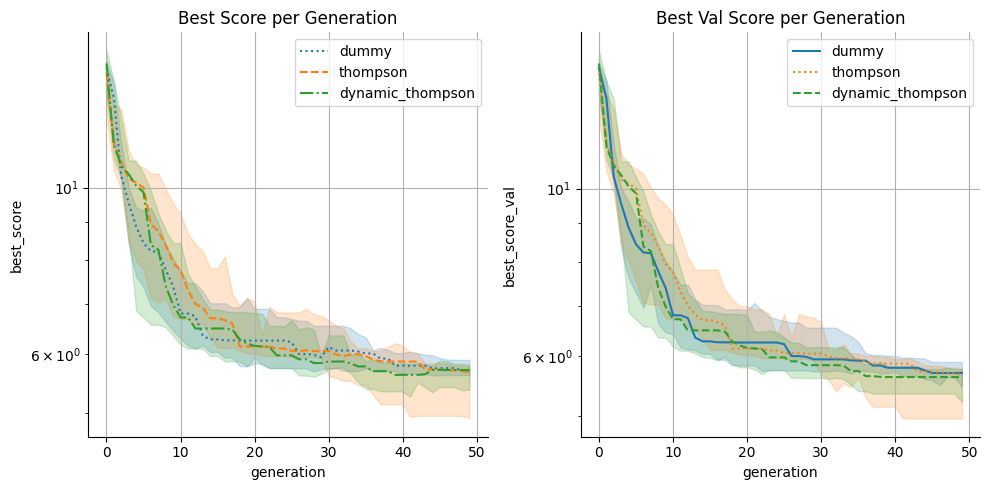

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

lines = [":","--","-.", "-"]
linecycler = cycle(lines)

for i, col in enumerate(['best_score', 'best_score_val']):
    for bandit in bandits:
        bandit_df = pd.concat([experiment['log'] for experiment in results[bandit]], axis=0)
        sns.lineplot(bandit_df, x='generation', y=col, ls=next(linecycler), label=bandit, ax=axs[i], estimator=np.nanmedian, errorbar='ci')
    sns.despine()
    axs[i].grid()
    axs[i].set_yscale('log')

axs[0].set_title('Best Score per Generation')
axs[1].set_title('Best Val Score per Generation')
plt.legend()
plt.tight_layout()

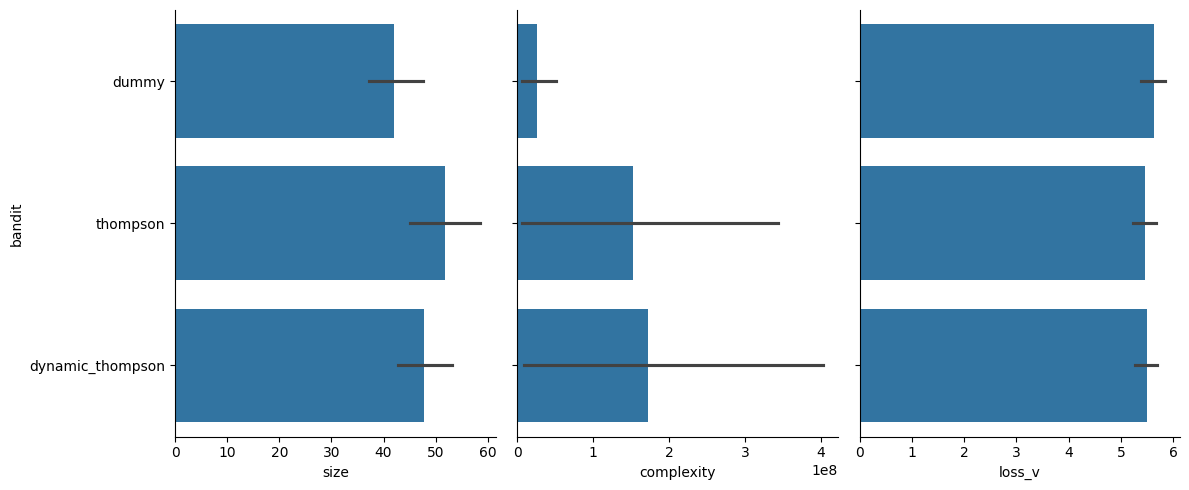

In [13]:
frames = []
for bandit in bandits:
    for experiment in results[bandit]:
        frames.append({
            'bandit'        : bandit,
            'run'           : experiment['run'],
            'model'         : experiment['model'],
            'size'          : experiment['size'],
            'loss_v'        : experiment['loss_v'],
            'complexity'    : experiment['complexity']
        })

df = pd.DataFrame(frames)

fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

for i, col in enumerate(['size', 'complexity', 'loss_v']):
    sns.barplot(df, y='bandit', x=col, ax=axs[i])
    sns.despine()
    
plt.tight_layout()